# 0) 모듈 실행

##기본 모듈

In [1]:
# Matplotlib 와 pandas 그래프에서 한글 사용 설정
import sys

## 노트북이 코랩에서 실행중인지 체크
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/frontend select Noninterative' | debconf-set-selections
  ## 나눔 폰트 설치
  !sudo apt-get -qq -y install fonts-nanum
  import matplotlib.font_manager as fm
  font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
  for fpath in font_files:
    fm.fontManager.addfont(fpath)

  # 나눔바른고딕 폰트 설정
  import matplotlib.pyplot as plt
  plt.rc('font', family='NanumBarunGothic')
  # 마이너스 기호 표시 오류 수정
  import matplotlib
  matplotlib.rcParams['axes.unicode_minus'] = False


In [2]:
!pip install konlpy

In [3]:
!apt-get update -qq

In [4]:
!apt-get install fonts-nanum*  -qq

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## KoBERT 설치
- 서비스 작동 중지로 인해 hugging face를 통해 모델 다운로드 전환
- https://complexoftaste.tistory.com/2

In [6]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

In [7]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-2mslg6e4/kobert-tokenizer_16c161a57bf6465fa931b1ceff0d708e
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-2mslg6e4/kobert-tokenizer_16c161a57bf6465fa931b1ceff0d708e
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [8]:
!pip3 install mxnet-mkl==1.6.0 numpy==1.23.1

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [10]:
# ★ Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')

In [12]:
# ★
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]') # 어휘 사전으로 토크나이저에 의해 생성

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

# 1) 데이터 가져오기

감성대화 말뭉치

https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86
- 일반인 1,500명 대상의 인터뷰 및 크라우드 소싱 수행
- 우울증 환자 대상 WOZ 대화 수집

=> 전처리 과정으로 "한사람만의 대화를 줄글로 변형 - 질문 제거"

### 1. 데이터 가져오기

In [13]:
train = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Training_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Training.xlsx")
valid = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Validation_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Validation.xlsx")

In [14]:
train_df = train.copy()
valid_df = valid.copy()

### 2. 전처리

In [15]:
# "사람문장3" 결측값 대체
train_df.fillna('',inplace=True)
valid_df.fillna('',inplace=True)

# 문장 병합
train_df['사람문장'] = train_df['사람문장1']+ " " +train_df['사람문장2']+ " " +train_df['사람문장3']
valid_df['사람문장'] = valid_df['사람문장1']+ " " +valid_df['사람문장2']+ " " + valid_df['사람문장3']

# "감정 분류"과 "문장"만 추출
train_df = train_df[['사람문장', '감정_대분류']]
valid_df = valid_df[['사람문장', '감정_대분류']]

# 컬럼명 변경
train_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)
valid_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)

# label encoding
le = LabelEncoder()
le=le.fit(train_df['sentiment'])
train_df['target']=le.transform(train_df['sentiment'])

le=le.fit(valid_df['sentiment'])
valid_df['target']=le.transform(valid_df['sentiment'])

# text, target
train_conv = train_df[['text','target']]
valid_conv = valid_df[['text','target']]

<ipython-input-15-c86074f96f8a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={'사람문장': 'text',
<ipython-input-15-c86074f96f8a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df.rename(columns={'사람문장': 'text',
<ipython-input-15-c86074f96f8a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['target']=le.transform(train_df['sentiment'])

In [16]:
'''# 정규표현식으로 한국어만 남기기
import re
from tqdm import tqdm

def removing_non_korean(df):
    for idx, row in tqdm(df.iterrows(), desc='removing_non_korean', total=len(df)):
        new_doc = re.sub('[^가-힣]', ' ', row['text']).strip() # 특수문자 제거
        df.loc[idx, 'document'] = new_doc
    return df

# 적용
train_conv['text'] = removing_non_korean(train_conv[['text']])['document']
valid_conv['text'] = removing_non_korean(valid_conv[['text']])['document']'''

"# 정규표현식으로 한국어만 남기기\nimport re\nfrom tqdm import tqdm\n\ndef removing_non_korean(df):\n    for idx, row in tqdm(df.iterrows(), desc='removing_non_korean', total=len(df)):\n        new_doc = re.sub('[^가-힣]', ' ', row['text']).strip() # 특수문자 제거\n        df.loc[idx, 'document'] = new_doc\n    return df\n\n# 적용\ntrain_conv['text'] = removing_non_korean(train_conv[['text']])['document']\nvalid_conv['text'] = removing_non_korean(valid_conv[['text']])['document']"

In [17]:
# 라벨 인코딩 결과 확인
sentiment = train_df[['sentiment', 'target']].drop_duplicates(subset=['sentiment']) # sentiment 컬럼에 대해 중복된 값을 갖고 있는 열 제거
df_unique = sentiment.sort_values(by='target', ascending=True)
df_unique = df_unique.reset_index(drop=True)
df_unique

,sentiment,target
0,기쁨,0
1,당황,1
2,분노,2
3,불안,3
4,상처,4
5,슬픔,5


# 2) 데이터 증강
데이터 불균형으로 인해 분류 전에 전처리하는 방식인 smote 택함

**SMOTE(= Synthetic Minority Over-sampling Technique)**

SMOTE는 합성을 기반으로 하는 방법으로, minority class의 샘플을 가져와 이들을 잇는 선에서 중간값을 택하여 만들어내는 방식

Train

In [18]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = train_conv.text.to_numpy().reshape(-1, 1)
target = train_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
train_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
train_conv2

,text,target
0,일은 왜 해도 해도 끝이 없을까? 화가 난다. 그냥 내가 해결하는 게 나아. 남들한...,2
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....,2
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,2
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,2
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나. 상사인 나에게 ...,2
...,...,...
55915,참여 인원 제한 때문에 내 이름을 뺀 작품이 입상했어. 기분이 별로야. 열심히 참여...,5
55916,내가 기대한 회사와 현실의 회사가 다르니 상당히 환멸이 난다. 왜 나는 과거에 이 ...,5
55917,우리 세대는 자녀들 키워내고 부모님 봉양하느라 노후준비는 뒷전일 수밖에 없었네. ...,5
55918,요즘 뼈가 자주 골절됐었는데 알고 보니 골다공증 때문이었어. 움직이면 무릎이 아파서...,5


valid

In [19]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = valid_conv.text.to_numpy().reshape(-1, 1)
target = valid_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
valid_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
valid_conv2

,text,target
0,이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너...,3
1,회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워. 나에게 너무 크...,3
2,상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워. 무섭게 생겼는데도 업무를 보려...,3
3,이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다. 첫 직장...,3
4,직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼. 내가 낯가림이 심해서 친해질 수...,3
...,...,...
7537,친한 친구가 내가 넘어질 때 손을 잡아주지 않았어. 뭔가 배신당한 것 기분이라 속상...,5
7538,평소에 괜찮다고 생각했던 팀장님이 술에 취하니까 아주 엉망이더라. 끔찍했어. 나에게...,5
7539,이렇게 나만 노력해서 일해 봤자 누가 알아주나 싶어서 슬퍼. 거기다 나이가 많다 보...,5
7540,딸 때문에 눈물이 나. 내 딸이 공부를 너무 안 해.,5


In [20]:
# 데이터셋이 잘 나눠져있는지 확인
print(len(train_conv2))
print(len(valid_conv2))

55920
7542


# 3) 데이터 전처리
모델 적합을 위해 데이터가 적절히 전처리되어야 하며 이때 전처리는 토큰화, 정수 인코딩, 패딩을 의미함

- https://velog.io/@seolini43/KOBERT%EB%A1%9C-%EB%8B%A4%EC%A4%91-%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EA%B8%B0-%ED%8C%8C%EC%9D%B4%EC%8D%ACColab

BERT는 이미 누군가가 학습해둔 모델을 사용하기 때문에 모델과 토크나이저가 항상 매핑되는 관계여야 함
- https://hoit1302.tistory.com/159
- https://github.com/SKTBrain/KoBERT/blob/master/kobert_hf/kobert_tokenizer/kobert_tokenizer.py

In [21]:
import re
# 텍스트 클린징 함수 정의
def clean_text(text):
    # 특수문자 제거
    text = re.sub(r'[^가-힣A-Za-z0-9 ]', '', text)

    # 여러 개의 공백은 하나로 줄이기
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [22]:
train_df = train_conv2.copy()
test_df = valid_conv2.copy()

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [23]:
dataset_train = train_df
dataset_test = test_df

In [24]:
dataset_test

,text,target
0,이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어 너무...,3
1,회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워 나에게 너무 크게...,3
2,상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워 무섭게 생겼는데도 업무를 보려면...,3
3,이번에 힘들게 들어간 첫 직장이거든 첫 직장이라서 그런지 너무 긴장된다 첫 직장이어...,3
4,직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼 내가 낯가림이 심해서 친해질 수 ...,3
...,...,...
7537,친한 친구가 내가 넘어질 때 손을 잡아주지 않았어 뭔가 배신당한 것 기분이라 속상해...,5
7538,평소에 괜찮다고 생각했던 팀장님이 술에 취하니까 아주 엉망이더라 끔찍했어 나에게 여...,5
7539,이렇게 나만 노력해서 일해 봤자 누가 알아주나 싶어서 슬퍼 거기다 나이가 많다 보니...,5
7540,딸 때문에 눈물이 나 내 딸이 공부를 너무 안 해,5


In [25]:
train_data_list = []
for label, q  in zip(dataset_train['target'], dataset_train['text'])  :
    data = []
    data.append(q)
    data.append(str(label))

    train_data_list.append(data)

#train_data_list

test_data_list = []
for label, q in zip(dataset_test['target'], dataset_test['text'])  :
    data = []
    data.append(q)
    data.append(str(label))

    test_data_list.append(data)

#test_data_list

dataset_train = train_data_list
dataset_test = test_data_list

In [26]:
text = dataset_train[70]
print(text)

# KoBERTTokenizer를 사용하여 토큰화
tokenized = tokenizer(text[0], return_tensors='pt')
print(tokenized)

# 토큰화된 입력을 평평하게 만듦
flat_input_ids = tokenized['input_ids'].view(-1)
print(flat_input_ids)

# 토큰 ID를 단어로 변환하여 출력
decoded = tokenizer.decode(flat_input_ids) # 문장을 모델의 인풋 토큰값으로 변경
print(decoded.split())

['날 면접에서 떨어뜨린 회사에서 만드는 물건은 사지도 않을 거야 정말 화가 나 인재를 못 알아본 그 회사가 나쁜 거야 분명 그 회사 물건도 좋지 못할 것 같아', '2']
{'input_ids': tensor([[   2, 1407, 2032, 6903, 1856, 6855, 5991, 6133, 5156, 6903, 1938, 2137,
         7086, 2573, 7328, 3163,  862, 6844, 4102, 5112, 5330, 1370, 3784, 6116,
         2086, 3175, 6383, 1185, 5156, 5330, 1380,  862, 6844, 2474, 1185, 5156,
         2137, 5859, 4210, 2091,  905,  832,    3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([   2, 1407, 2032, 6903, 1856, 6855, 5991, 6133, 5156, 6903, 1938, 2137,
        7086, 2573, 7328, 3163,  862, 6844, 4102, 5112, 5330, 1370, 3784, 6116,
        2086, 3175, 6383, 1185, 5156, 5330, 1380,  862, 6844, 2474, 1185, 5156,
        2137, 58

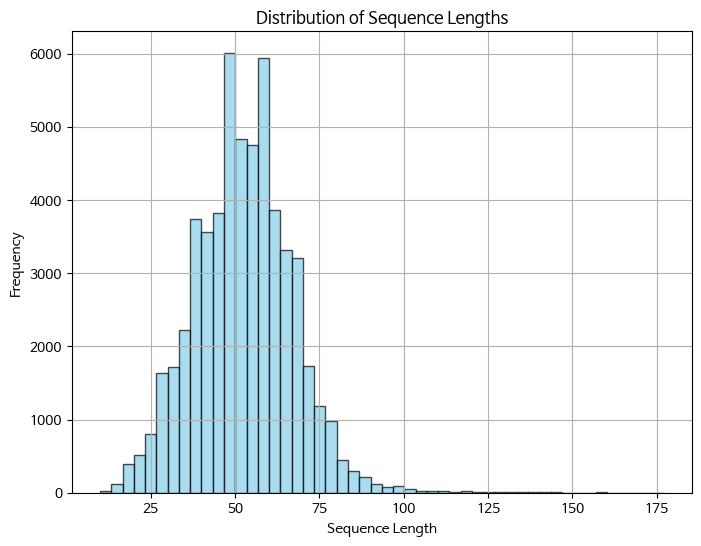

리뷰 토큰 개수 최대 값: 177
리뷰 토큰 개수 최소 값: 10
리뷰 토큰 개수 평균 값: 52.63
리뷰 토큰 개수 표준편차: 14.68
리뷰 토큰 개수 중간 값: 53.0
리뷰 토큰 개수 제 1 사분위: 43.0
리뷰 토큰 개수 제 3 사분위: 62.0


In [27]:
import matplotlib.pyplot as plt

# 각 데이터의 토큰화된 입력을 저장할 리스트
tokenized_inputs = []

# 텍스트 데이터셋을 순회하며 토큰화하고 평평한 입력으로 변환
for text_data in dataset_train:
    # KoBERTTokenizer를 사용하여 토큰화
    tokenized = tokenizer(text_data[0], return_tensors='pt')
    # 토큰화된 입력을 평평하게 만들어 리스트에 저장
    flat_input_ids = tokenized['input_ids'].view(-1)
    tokenized_inputs.append(flat_input_ids)

# 각 데이터의 시퀀스 길이를 저장할 리스트
sequence_lengths = [len(tokens) for tokens in tokenized_inputs]

# 시퀀스 길이의 분포를 시각화
plt.figure(figsize=(8, 6))
plt.hist(sequence_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

train_bert_token_counts = sequence_lengths
print('리뷰 토큰 개수 최대 값: {}'.format(np.max(train_bert_token_counts)))
print('리뷰 토큰 개수 최소 값: {}'.format(np.min(train_bert_token_counts)))
print('리뷰 토큰 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('리뷰 토큰 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('리뷰 토큰 개수 중간 값: {}'.format(np.median(train_bert_token_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 토큰 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('리뷰 토큰 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))

In [28]:
# Setting parameters - base
max_len = 64 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 32 # GPU 메모리가 너무 작아서
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [29]:
class BERTSentenceTransform:

    def __init__(self, tokenizer, max_seq_length, vocab=None, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = self._tokenizer.vocab if vocab is None else vocab

        # [CLS], [SEP] 토큰 설정
        if hasattr(self._vocab, 'cls_token'):
            self._cls_token = self._vocab.cls_token
        else:
            self._cls_token = self._vocab.bos_token
        if hasattr(self._vocab, 'sep_token'):
            self._sep_token = self._vocab.sep_token
        else:
            self._sep_token = self._vocab.eos_token
        self._padding_token = self._vocab.padding_token

    # BERT 모델 입력 생성
    def __call__(self, line):
        # 입력 문장 설정
        text_a = line[0] # line (str or tuple): 입력 문장 또는 (문장1, 문장2) 튜플
        if self._pair:
            assert len(line) == 2
            text_b = line[1]
        # 토큰화
        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer.tokenize(text_b)

        if tokens_b:
            # 시퀀스 길이 제한
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]
        # 토큰 및 세그먼트 ID 설정
        tokens = []
        tokens.append(self._cls_token)
        tokens.extend(tokens_a)
        tokens.append(self._sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(self._sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._vocab[tokens]
        # 유효 길이 계산
        valid_length = len(input_ids)
        # 패딩 : 토큰을 정수 인덱스로 변환하고 패딩을 추가
        if self._pad:
            padding_length = self._max_seq_length - valid_length
            input_ids.extend([self._vocab[self._padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)
        # BERT 모델 입력으로 변환된 튜플
        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'), np.array(segment_ids, dtype='int32')

    # 두 개의 시퀀스를 주어진 최대 길이로 자르는 함수
    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        while True:
            total_length = len(tokens_a) + len(tokens_b) # 첫번째 시퀀스의 토큰 리스트, 두번째 시퀀스의 토큰 리스트
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()


- 문장을 토큰화하고 특수 토큰([CLS], [SEP])을 추가
- 토큰을 정수 인덱스로 변환하고 패딩을 추가
- 옵션에 따라 문장 페어를 처리(문장 페어가 있는 경우 [SEP] 토큰을 사용하여 두 번째 문장을 추가합니다).

In [30]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer,
                                          max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [31]:
#토큰화
tok = tokenizer.tokenize

dataset_train = dataset_train
dataset_test = dataset_test

data_train = BERTDataset(dataset_train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

In [32]:
# torch 형식의 dataset을 만들어 입력 데이터셋의 전처리 마무리
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 4) Kobert 모델 구현
- https://velog.io/@jaylnne/Pytorch-Lightning-%EC%9C%BC%EB%A1%9C-koBERT-Fine-Tuning-%ED%95%B4%EB%B3%B4%EA%B8%B0-NSMC

In [33]:
# koBERT 학습모델 만들기
# 다중분류할 클래스 수 만큼 num_classes 변수를 수정 (6가지의 class 분류)
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 6,   # 감정 클래스 수로 조정
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [34]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device) # 드롭아웃 적용

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func : 학습이 진행됨에 따라 epoch 또는 iteration 간에 학습률을 조정하는 사전 정의된 프레임워크

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


학습

- https://github.com/TaesunPark/Sentiment-Analysis/blob/e69a11a4e4233572fd27a340a3e369d2d00a0eac/%ED%85%8D%EC%8A%A4%ED%8A%B8%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D.ipynb#L220

In [35]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0

    # 학습
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
          print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval() # 평가모드로 변경

    # 평가
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-35-da69000ed3d5>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/1748 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.88118314743042 train acc 0.1875
epoch 1 batch id 201 loss 1.7528102397918701 train acc 0.1935634328358209
epoch 1 batch id 401 loss 1.5016275644302368 train acc 0.29052369077306733
epoch 1 batch id 601 loss 0.8619934916496277 train acc 0.37515599001663896
epoch 1 batch id 801 loss 0.08129377663135529 train acc 0.4401919475655431
epoch 1 batch id 1001 loss 0.5356960892677307 train acc 0.4600711788211788
epoch 1 batch id 1201 loss 1.7725558280944824 train acc 0.4863134887593672
epoch 1 batch id 1401 loss 0.7814136147499084 train acc 0.49219307637401855
epoch 1 batch id 1601 loss 0.5192685127258301 train acc 0.5217637414116177
epoch 1 train acc 0.5488236556064073


<ipython-input-35-da69000ed3d5>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/236 [00:00<?, ?it/s]

epoch 1 test acc 0.16777012711864406


  0%|          | 0/1748 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 4.191882133483887 train acc 0.125
epoch 2 batch id 201 loss 1.869545340538025 train acc 0.1921641791044776
epoch 2 batch id 401 loss 1.7683721780776978 train acc 0.1805642144638404
epoch 2 batch id 601 loss 1.8148216009140015 train acc 0.17746464226289518
epoch 2 batch id 801 loss 2.406466484069824 train acc 0.17208957553058676
epoch 2 batch id 1001 loss 1.7819292545318604 train acc 0.17111013986013987
epoch 2 batch id 1201 loss 1.7260349988937378 train acc 0.1704308909242298
epoch 2 batch id 1401 loss 1.618719458580017 train acc 0.17701641684511063
epoch 2 batch id 1601 loss 1.6574150323867798 train acc 0.17988757026858213
epoch 2 train acc 0.20961455949656752


  0%|          | 0/236 [00:00<?, ?it/s]

epoch 2 test acc 0.1664459745762712


  0%|          | 0/1748 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 3.359485387802124 train acc 0.1875
epoch 3 batch id 201 loss 1.8123278617858887 train acc 0.18034825870646767
epoch 3 batch id 401 loss 1.694712519645691 train acc 0.180642144638404
epoch 3 batch id 601 loss 1.8401367664337158 train acc 0.1767366888519135
epoch 3 batch id 801 loss 2.2231550216674805 train acc 0.17220661672908863
epoch 3 batch id 1001 loss 1.8904777765274048 train acc 0.170516983016983
epoch 3 batch id 1201 loss 1.7777339220046997 train acc 0.1720961698584513
epoch 3 batch id 1401 loss 1.588133454322815 train acc 0.17752944325481798
epoch 3 batch id 1601 loss 0.5901407599449158 train acc 0.22587445346658339
epoch 3 train acc 0.26916475972540044


  0%|          | 0/236 [00:00<?, ?it/s]

epoch 3 test acc 0.1664459745762712


  0%|          | 0/1748 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 2.9592020511627197 train acc 0.1875
epoch 4 batch id 201 loss 1.288659691810608 train acc 0.28544776119402987
epoch 4 batch id 401 loss 1.4968595504760742 train acc 0.4044576059850374
epoch 4 batch id 601 loss 0.9227543473243713 train acc 0.47415765391014975
epoch 4 batch id 801 loss 0.07280401140451431 train acc 0.5237593632958801
epoch 4 batch id 1001 loss 0.47921115159988403 train acc 0.5421453546453546
epoch 4 batch id 1201 loss 1.587679386138916 train acc 0.5611729808492922
epoch 4 batch id 1401 loss 0.5972006916999817 train acc 0.5680317630264097
epoch 4 batch id 1601 loss 0.356151819229126 train acc 0.5933986570893192
epoch 4 train acc 0.6097683066361556


  0%|          | 0/236 [00:00<?, ?it/s]

epoch 4 test acc 0.5268682588597843


  0%|          | 0/1748 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.3896735906600952 train acc 0.59375
epoch 5 batch id 201 loss 0.9486465454101562 train acc 0.6103855721393034
epoch 5 batch id 401 loss 1.0492384433746338 train acc 0.6345854114713217
epoch 5 batch id 601 loss 0.7560082674026489 train acc 0.6462666389351082
epoch 5 batch id 801 loss 0.014815676026046276 train acc 0.6667446941323346
epoch 5 batch id 1001 loss 0.3678818345069885 train acc 0.6677697302697303
epoch 5 batch id 1201 loss 1.6864228248596191 train acc 0.670326810990841
epoch 5 batch id 1401 loss 0.8251463770866394 train acc 0.6482200214132763
epoch 5 batch id 1601 loss 0.6957148909568787 train acc 0.6499843847595252
epoch 5 train acc 0.6632937643020596


  0%|          | 0/236 [00:00<?, ?it/s]

epoch 5 test acc 0.6880176232665639


In [36]:
# 모델 전체 저장
torch.save(model, 'model_KoBert_0523.pt')
# 상태 파리미터 값만 저장
torch.save(model.state_dict(),  'model_state_dict.pt')  # 모델 객체의 state_dict 저장

torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
    },  'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [37]:
model

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

# 5) 모델 추가 학습

In [38]:
#model.load_state_dict(torch.load('model_KoBert_0523.pt'))
model.to(device)

# Setting parameters - base
max_len = 64 # 해당 길이를 초과하는 단어에 대해선 bert가 학습하지 않음
batch_size = 16 # GPU 메모리가 너무 작아서
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

# torch 형식의 dataset을 만들어 입력 데이터셋의 전처리 마무리
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 5)

# 추가학습 루프
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0

    # 학습
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
          print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval() # 평가모드로 변경

    # 평가
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

<ipython-input-38-0062fd8c1a26>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/3495 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.244450569152832 train acc 0.625
epoch 1 batch id 201 loss 0.6578460931777954 train acc 0.6859452736318408
epoch 1 batch id 401 loss 0.9064800143241882 train acc 0.6661471321695761
epoch 1 batch id 601 loss 0.5363253951072693 train acc 0.6720049916805324
epoch 1 batch id 801 loss 0.43864691257476807 train acc 0.6711142322097379
epoch 1 batch id 1001 loss 0.7697826623916626 train acc 0.6755744255744256
epoch 1 batch id 1201 loss 0.8738219738006592 train acc 0.677248126561199
epoch 1 batch id 1401 loss 1.262952446937561 train acc 0.6830389007851535
epoch 1 batch id 1601 loss 0.006871609948575497 train acc 0.6907792004996877
epoch 1 batch id 1801 loss 1.0820889472961426 train acc 0.6827109938922821
epoch 1 batch id 2001 loss 0.33337053656578064 train acc 0.6883433283358321
epoch 1 batch id 2201 loss 0.6017341017723083 train acc 0.6920433893684689
epoch 1 batch id 2401 loss 1.1213626861572266 train acc 0.6877863390254061
epoch 1 batch id 2601 loss 1.527924776077270

<ipython-input-38-0062fd8c1a26>:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/472 [00:00<?, ?it/s]

epoch 1 test acc 0.23035840395480228


  0%|          | 0/3495 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 2.6950645446777344 train acc 0.0
epoch 2 batch id 201 loss 0.8572208881378174 train acc 0.6075870646766169
epoch 2 batch id 401 loss 1.113257646560669 train acc 0.6231296758104738
epoch 2 batch id 601 loss 0.562083899974823 train acc 0.6377911813643927
epoch 2 batch id 801 loss 0.9830785989761353 train acc 0.6410736579275905
epoch 2 batch id 1001 loss 0.9304412007331848 train acc 0.644542957042957
epoch 2 batch id 1201 loss 0.7929657101631165 train acc 0.6428497085761865
epoch 2 batch id 1401 loss 1.537825107574463 train acc 0.6494022127052106
epoch 2 batch id 1601 loss 0.002958041848614812 train acc 0.6581823860087446
epoch 2 batch id 1801 loss 1.2321321964263916 train acc 0.6469322598556357
epoch 2 batch id 2001 loss 0.26993879675865173 train acc 0.653891804097951
epoch 2 batch id 2201 loss 0.8020450472831726 train acc 0.6587062698773285
epoch 2 batch id 2401 loss 1.4602104425430298 train acc 0.6558204914618909
epoch 2 batch id 2601 loss 1.5427225828170776 tra

  0%|          | 0/472 [00:00<?, ?it/s]

epoch 2 test acc 0.16777012711864406


  0%|          | 0/3495 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 3.4819650650024414 train acc 0.0
epoch 3 batch id 201 loss 1.7744110822677612 train acc 0.1921641791044776
epoch 3 batch id 401 loss 1.7174303531646729 train acc 0.18204488778054864
epoch 3 batch id 601 loss 1.3632200956344604 train acc 0.26643094841930115
epoch 3 batch id 801 loss 0.38730981945991516 train acc 0.35369850187265917
epoch 3 batch id 1001 loss 1.4930733442306519 train acc 0.4102147852147852
epoch 3 batch id 1201 loss 0.6001429557800293 train acc 0.4475957535387177
epoch 3 batch id 1401 loss 1.3303265571594238 train acc 0.47894361170592437
epoch 3 batch id 1601 loss 0.012070324271917343 train acc 0.5065193628981887
epoch 3 batch id 1801 loss 1.2071870565414429 train acc 0.509959744586341
epoch 3 batch id 2001 loss 0.7595482468605042 train acc 0.5314842578710645
epoch 3 batch id 2201 loss 0.5405320525169373 train acc 0.5479043616537937
epoch 3 batch id 2401 loss 1.2089751958847046 train acc 0.5547428154935443
epoch 3 batch id 2601 loss 1.60107421875 

  0%|          | 0/472 [00:00<?, ?it/s]

epoch 3 test acc 0.17558262711864406


  0%|          | 0/3495 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 3.353363275527954 train acc 0.0
epoch 4 batch id 201 loss 0.7711665034294128 train acc 0.45180348258706465
epoch 4 batch id 401 loss 0.9874504804611206 train acc 0.5525249376558603
epoch 4 batch id 601 loss 0.4648078978061676 train acc 0.5947379367720466
epoch 4 batch id 801 loss 0.9880791902542114 train acc 0.6154806491885143
epoch 4 batch id 1001 loss 0.8820452690124512 train acc 0.631993006993007
epoch 4 batch id 1201 loss 0.6086308360099792 train acc 0.6400915903413822
epoch 4 batch id 1401 loss 1.3981775045394897 train acc 0.6512758743754461
epoch 4 batch id 1601 loss 0.003072756342589855 train acc 0.6643113678950656
epoch 4 batch id 1801 loss 1.1929736137390137 train acc 0.659876457523598
epoch 4 batch id 2001 loss 0.2763653099536896 train acc 0.6724450274862569
epoch 4 batch id 2201 loss 0.4449339509010315 train acc 0.6812244434348024
epoch 4 batch id 2401 loss 1.124277114868164 train acc 0.683387130362349
epoch 4 batch id 2601 loss 1.2643349170684814 tra

  0%|          | 0/472 [00:00<?, ?it/s]

epoch 4 test acc 0.6362111581920904


  0%|          | 0/3495 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.5217297077178955 train acc 0.5625
epoch 5 batch id 201 loss 0.7620373964309692 train acc 0.7133084577114428
epoch 5 batch id 401 loss 0.9266387224197388 train acc 0.7104114713216958
epoch 5 batch id 601 loss 0.26685580611228943 train acc 0.7189059900166389
epoch 5 batch id 801 loss 0.37510111927986145 train acc 0.7224563046192259
epoch 5 batch id 1001 loss 0.6355539560317993 train acc 0.7249000999000998
epoch 5 batch id 1201 loss 0.4944004416465759 train acc 0.725176935886761
epoch 5 batch id 1401 loss 1.3316638469696045 train acc 0.7318433261955746
epoch 5 batch id 1601 loss 0.004194220993667841 train acc 0.7406308557151781
epoch 5 batch id 1801 loss 1.2155091762542725 train acc 0.7326138256524153
epoch 5 batch id 2001 loss 0.29601457715034485 train acc 0.7413793103448276
epoch 5 batch id 2201 loss 0.5448168516159058 train acc 0.7469048159927306
epoch 5 batch id 2401 loss 1.1631405353546143 train acc 0.7465899625156185
epoch 5 batch id 2601 loss 1.66627836227

  0%|          | 0/472 [00:00<?, ?it/s]

epoch 5 test acc 0.6409781073446328


# 6) 테스트

In [ ]:
def predict(sentence):
    dataset = [[sentence, '0']]
    test = BERTDataset(dataset, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=2)
    model.eval()
    answer = 0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        for logits in out:
            logits = logits.detach().cpu().numpy()
            answer = np.argmax(logits)
    return answer

In [ ]:
test_sentence = '음식을 잘못 먹었나봐요... 발열, 구토, 복통, 설사 증상이 있어요.'
predict(test_sentence)

AttributeError: 'function' object has no attribute 'tokenize'

In [ ]:
def predict(predict_sentence): # input = 감정분류하고자 하는 sentence

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False) # 토큰화한 문장
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size = batch_size, num_workers = 5) # torch 형식 변환

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval = []
        for i in out: # out = model(token_ids, valid_length, segment_ids)
            logits = i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("기쁨")
            elif np.argmax(logits) == 1:
                test_eval.append("당황")
            elif np.argmax(logits) == 2:
                test_eval.append("분노")
            elif np.argmax(logits) == 3:
                test_eval.append("뷸언")
            elif np.argmax(logits) == 4:
                test_eval.append("상처")
            elif np.argmax(logits) == 5:
                test_eval.append("슬픔")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [ ]:
# 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

In [ ]:
# 테스트 문장 예측
test_sentence = '음식을 잘못 먹었나봐요... 발열, 구토, 복통, 설사 증상이 있어요.'
test_label = 7 # 실제 질병

unseen_test = pd.DataFrame([[test_sentence, test_label]], columns = [['질문 내용', '질병명']])
unseen_values = unseen_test.values
test_set = BERTDataset(unseen_values, 0, 1, tok, max_len, True, False)
test_input = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=5)

for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_input)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  out = model(token_ids, valid_length, segment_ids)
  print(out)